In [6]:
import torch
import fastai
from fastbook import *
import timm
print(f' Fastai {fastai.__version__}\nPytorch {torch.__version__}\n   Timm {timm.__version__}')
try:
    free, total = torch.cuda.mem_get_info()
    print(f'    GPU {torch.cuda.get_device_name(0)} ({total//1024**2} MB)')
except: print("No GPU detected")

 Fastai 2.7.7
Pytorch 1.12.0
   Timm 0.6.2.dev0
    GPU GeForce GTX 1060 (6144 MB)


# 🖼️ CNN prediction constriction
🐈 Cats vs. Dogs 🐶

In [83]:
path = untar_data(URLs.PETS)/'images'

def is_cat(x): 
    return x[0].isupper()

# data loader
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224), bs=64)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [8]:
# resnet learner
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.142583,0.031935,0.010149,01:29


epoch,train_loss,valid_loss,error_rate,time
0,0.074698,0.026516,0.007442,01:35
1,0.027628,0.022916,0.004736,01:38


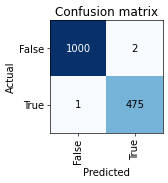

In [4]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(3,3), dpi=60)

### Top Losses

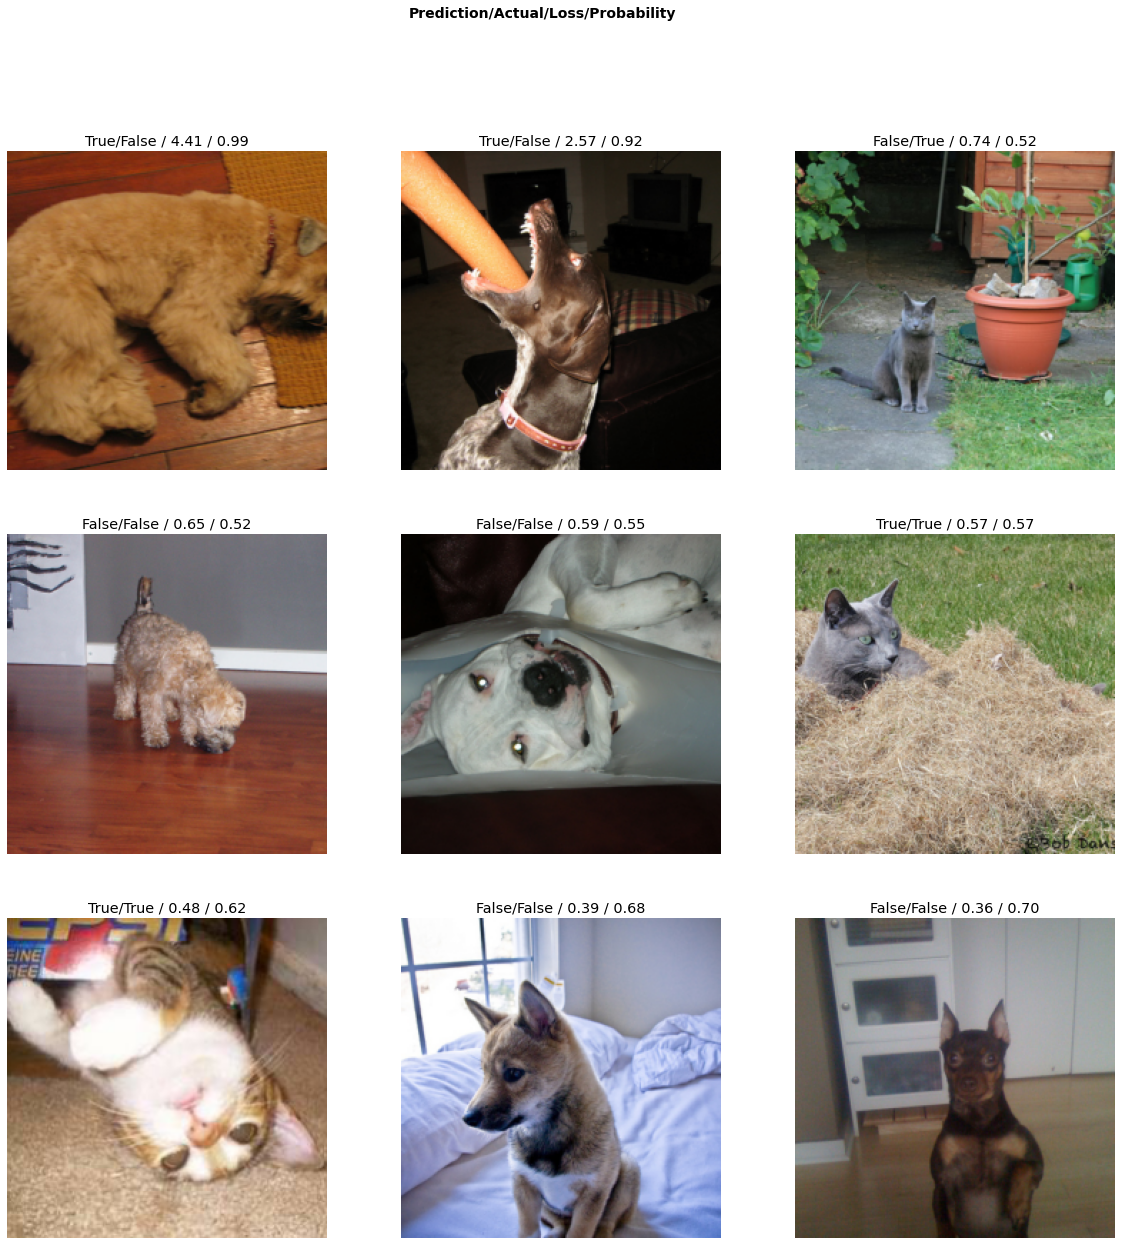

In [34]:
# label function: is_cat?
interp.plot_top_losses(9, nrows=3, figsize=(20,20))

Example of a test image that was a false negative:

torch.Size([1, 3, 224, 224])


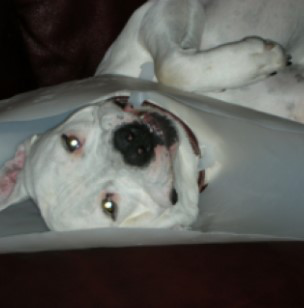

In [53]:
img = PILImage.create("..\img\catdog2.jpg")
x, = first(dls.test_dl([img]))         
print(x.shape)
img

In [54]:
# add hook to final activation layer
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

with torch.no_grad(): output = learn.model.eval()(x)
act = hook_output.stored[0]

# double check prediction (dog)
F.softmax(output, dim=-1)

TensorBase([[0.9135, 0.0865]], device='cuda:0')

TensorBase([[0.9135, 0.0865]], device='cuda:0')


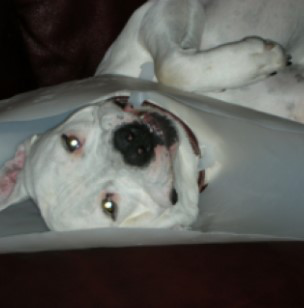

In [62]:
img = PILImage.create("..\img\catdog2.jpg")
x, = first(dls.test_dl([img]))         

with torch.no_grad(): output = learn.model.eval()(x)
print(F.softmax(output, dim=-1))

img

TensorBase([[0.9795, 0.0205]], device='cuda:0')


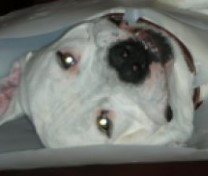

In [63]:
img = PILImage.create("..\img\catdog2.02.jpg")
x, = first(dls.test_dl([img]))         

with torch.no_grad(): output = learn.model.eval()(x)
print(F.softmax(output, dim=-1))  

img

TensorBase([[0.9869, 0.0131]], device='cuda:0')


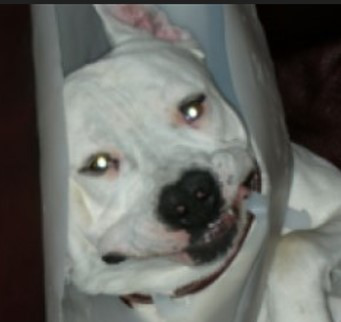

In [67]:
img = PILImage.create("..\img\catdog2.01.jpg")
x, = first(dls.test_dl([img]))         

with torch.no_grad(): output = learn.model.eval()(x)
print(F.softmax(output, dim=-1))   

img

In [86]:
tl = interp.top_losses()
tl

(TensorBase([4.4102, 2.5708, 0.7365,  ..., -0.0000, -0.0000, -0.0000]),
 TensorBase([ 327,  448,  599,  ..., 1475,  781, 1295]))

TensorBase([327, 448, 599, 276, 821, 610])


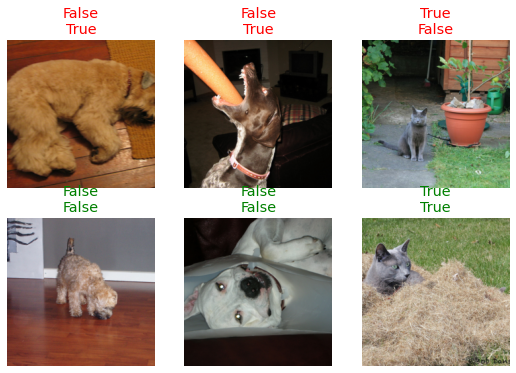

In [101]:
tl_idxs = tl[1][:6]
print(tl_idxs)
interp.show_results(idxs=tl_idxs)

In [110]:
torch.set_printoptions(sci_mode=False)

Cat 1.000
TensorBase([[    0.0001,     0.9999]], device='cuda:0')


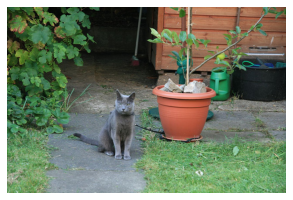

In [160]:
def get_sample(n=0):
    """Get image from dataset and pass through pre-processing"""
    img = PILImage.create(dls.valid_ds.items[n])
    x, = first(dls.test_dl([img]))
    return img, x

def show_sample(n=0):
    img, x = get_sample(n=n)
    with torch.no_grad(): output = learn.model.eval()(x)
    pred = F.softmax(output, dim=-1)
    
    pred = F.softmax(output, dim=-1)

    if pred[0][0]>=0.5: ans = f"Dog {pred[0][0]:0.3f}"
    else: ans = f"Cat {pred[0][1]:0.3f}"

    print(ans, pred, sep='\n')
    img.show();

show_sample(599)

Cat 0.956
TensorBase([[0.0442, 0.9558]], device='cuda:0')


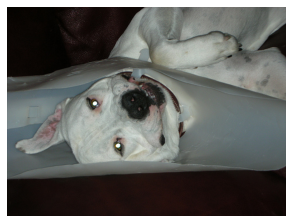

In [161]:
show_sample(821)

Dog 1.000
TensorBase([[    1.0000,     0.0000]], device='cuda:0')


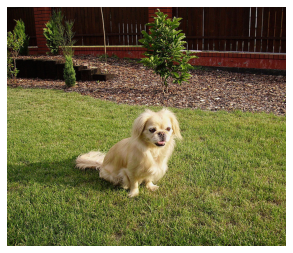

In [162]:
show_sample(13)